# 尤度函数のプロット

黒木玄

2019-09-17

## 追記
- [黒木さんオリジナル](https://github.com/genkuroki/Statistics/blob/master/likelihood%20functions%20of%20mixture%20normal%20distributions.ipynb), [nbviewer](https://nbviewer.jupyter.org/github/genkuroki/Statistics/blob/master/likelihood%20functions%20of%20mixture%20normal%20distributions.ipynb)

上記リンク先のファイルにコメントをつけています。

このノートブックでは「二つの山」を持つパラメータつきの確率分布$p(x|a,b)$を考え、次のようにふるまうとします。

- 二つの山は$b$が大きいとき（**正則なとき**）は分離して見える。
- 二つの山は$b$が小さくなるとき（**特異なとき**）山が合体して見える。

このとき$b$の大小で尤度関数（のヒートマップ）がどう見えるかを具体的に調べてみます。
特に次の二つの場合を考えます。

- パラメータ$(a_i, b_i)$ ($i=1,2,3,4$) に対してそれぞれ**サンプル数$n$を変えた時**にどうふるまうか？
- パラメータ$(a_i, b_i)$ ($i=1,2,3,4$) に対して**サンプル数を固定**して乱数のシードを変えたときどう振る舞うか？

サンプル$X$は上記特定のパラメータで作り、同じ関数$p(x|a,b)$から作った$L(a,b)=p(X|a,b)$でヒートマップを作っています。

## 目次
- [確率分布のパラメータを変えつつ、$n$を変えて実験](#確率分布のパラメータを変えつつ、$n$を変えて実験)
    - [$(a_0,-b_0)-=-(0.5,-0.1)$-near-singular](#$(a_0,-b_0)-=-(0.5,-0.1)$-near-singular)
    - [$(a_1,-b_1)-=-(0.5,-0.5)$-regular](#$(a_1,-b_1)-=-(0.5,-0.5)$-regular)
    - [$(a_2,-b_2)-=-(0.5,-0.0)$-singular](#$(a_2,-b_2)-=-(0.5,-0.0)$-singular)
    - [$(a_3,-b_3)-=-(0.5,-4.0)$-very-regular](#$(a_3,-b_3)-=-(0.5,-4.0)$-very-regular)
- [n-=-256-で固定しつつ、乱数のシードを変えて実験](#n-=-256-で固定しつつ、乱数のシードを変えて実験)
    - [n-=-256,-$(a_0,-b_0)-=-(0.5,-0.1)$,-near-singular](#n-=-256,-$(a_0,-b_0)-=-(0.5,-0.1)$,-near-singular)
    - [n-=-256,-$(a_1,-b_1)-=-(0.5,-0.5)$,-regular](#n-=-256,-$(a_1,-b_1)-=-(0.5,-0.5)$,-regular)
    - [n-=-256-$(a_2,-b_2)-=-(0.5,-0.0)$,-singularr](#n-=-256,-$(a_2,-b_2)-=-(0.5,-0.0)$,-singular)
    - [n-=-256,-$(a_3,-b_3)-=-(0.5,-4.0)$,-very-regular](#n-=-256,-$(a_3,-b_3)-=-(0.5,-4.0)$,-very-regular)

## 準備

### ライブラリ読み込み

In [1]:
using Distributions
using Plots
gr(size=(400, 250), titlefontsize=10, fmt=:png)
using Random

### 定数設定

In [2]:
const s = 4649
Random.seed!(s)

# あとで n 固定でテストするときの変数
const loopnum = 16
const rands = rand(UInt, loopnum)

16-element Array{UInt64,1}:
 0xad6a8c96a37098b8
 0x78b29aa4ff33520c
 0x5005b9192dceadb2
 0x473ebba659aeceb7
 0x20f2f1f7fead8217
 0x8f2b974ecd2f511d
 0x3ad159aa61d6ef72
 0x2af445e5cb097489
 0x939112850fe8922c
 0xfcc13b0837e2c974
 0x8a0af76bbd11fbbb
 0x14f883a76f81cae3
 0x68bc88d65d971384
 0x62b687209e58f31b
 0x97c264f85fd75c5c
 0x98ba652b56d67aef

### 関数定義
\begin{align}
\mathrm{logp}(x | a,b) &=
- \frac{x^2}{2} - \log \sqrt{2 \pi} + \log 
\left(
(1-a) + a \exp \left[ bx - \frac{b^2}{2} \right]
\right), \\
p(x | a, b) &=
\exp \mathrm{logp}(x | a, b) \\ 
&=
\frac{1}{\sqrt{2\pi}}
e^{\frac{x^2}{2}} \left(
(1-a) + a \exp \left[ bx - \frac{b^2}{2} \right] 
\right).
\end{align}

#### 注意
あとでヒストグラムを見れば具体的にわかるように、
パラメータのうち$b$が小さいとき$p$は「二つの山」が区別しにくくなります。
この状況をもって$b$が小さい$p(x|a,b)$を**特異的**と呼び、そうでないときを正則と呼びます。
このノートブックのテーマは正則な場合と特異的な場合で尤度関数の振る舞いがどう変わるか調べることです。

In [3]:
# 上のセル参照
logp(x, a, b) = -x^2/2 - log(√(2π)) + log((1-a) + a*exp(b*x - b^2/2))
# サンプル生成に使う確率分布
p(x, a, b) = exp(logp(x, a, b))
# 対数尤度
loglik(X, a, b) = sum(logp(x, a, b) for x in X)
# 正規分布の混合モデル
mixnormal(a, b) = MixtureModel([Normal(), Normal(b, 1.0)], [1-a, a])

mixnormal (generic function with 1 method)

### 尤度関数のプロット用関数

In [4]:
function plot_lik(a₀, b₀, n; seed=s, alim=(0, 1), blim=(-1, 2), kwargs...)
    Random.seed!(seed)
    
    # 真の分布
    dist_true = mixnormal(a₀, b₀)
    # サンプル生成
    X = rand(dist_true, n)
    
    # 対数尤度関数の定義
    L(a, b) = loglik(X, a, b)

    # ヒートマップ用の範囲指定
    a = range(alim..., length=100)
    b = range(blim..., length=200)
    # 尤度の計算
    @time z = L.(a, b')
    zmax = maximum(z)
    idx = findmax(z)[2]
    w = @. exp(z - zmax) # is very important!

    plot!(; title="\$n = $n,\\quad (a_0, b_0) = ($(a₀), $(b₀))\$")
    plot!(; xlabel="\$b\$", ylabel="\$a\$")
    heatmap!(b, a, w; colorbar=false)
    # 真の値
    scatter!([b₀], [a₀]; markersize=4, markerstrokewidth=0, color=:cyan, label="true")
    # 最尤法：星型マーカー
    scatter!([b[idx[2]]], [a[idx[1]]]; markersize=5, markershape=:star, color=:lightgreen, label="MLE")
    plot!(; xlim=extrema(b), ylim=extrema(a))
    plot!(; kwargs...)
end

plot_lik (generic function with 1 method)

### 正則な場合：$(a,b)=(0.3, 5)$の混合正規分布のヒストグラムと分布

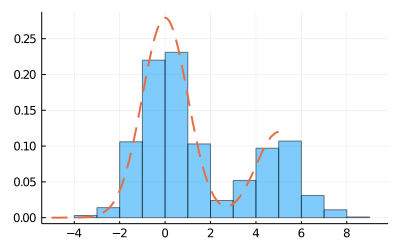

In [5]:
(a, b) = (0.3, 5)
histogram(rand(mixnormal(a, b), 1000), bin=20, normed=true, legend=false, alpha=0.5)
plot!(x->p(x, a, b), lw=2, ls=:dash, size=(400, 250))

### 特異性が強い場合：$(a,b)=(0.3, 0.1)$の混合正規分布のヒストグラムとサンプル

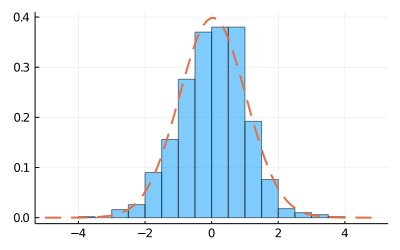

In [6]:
(a, b) = (0.3, 0.1)
histogram(rand(mixnormal(a, b), 1000), bin=20, normed=true, legend=false, alpha=0.5)
plot!(x->p(x, a, b), lw=2, ls=:dash, size=(400, 250))

### 特異的な場合：$(a,b)=(0.3, 0.0)$の混合正規分布のヒストグラムとサンプル

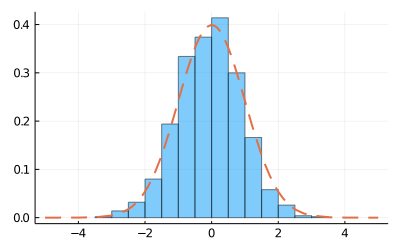

In [7]:
(a, b) = (0.3, 0.0)
histogram(rand(mixnormal(a, b), 1000), bin=20, normed=true, legend=false, alpha=0.5)
plot!(x->p(x, a, b), lw=2, ls=:dash, size=(400, 250))

## 確率分布のパラメータを変えつつ、$n$を変えて実験
- [目次](#目次)

### $(a_0, b_0) = (0.5, 0.1)$ near singular
- [目次](#目次)

#### まとめ
- $n$が増えるとヒートマップの範囲は細長くなっていく
- （ここで確認した範囲では）最後までヒートマップの裾野が広い
- 最尤法の位置（星型マーカー）もあまり精度がよくない

In [8]:
a₀, b₀ = 0.5, 0.1

(0.5, 0.1)

#### 尤度関数のプロット: $n=2^4$

  0.011178 seconds (2 allocations: 156.328 KiB)


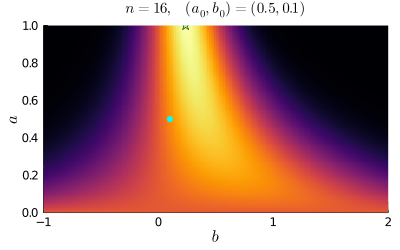

In [9]:
plot_lik(a₀, b₀, 2^4)

#### 尤度関数のプロット: $n=2^6$

  0.053374 seconds (2 allocations: 156.328 KiB)


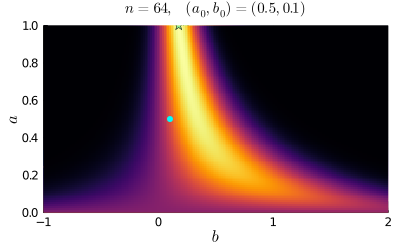

In [10]:
plot_lik(a₀, b₀, 2^6)

#### 尤度関数のプロット: $n=2^8$

  0.238222 seconds (2 allocations: 156.328 KiB)


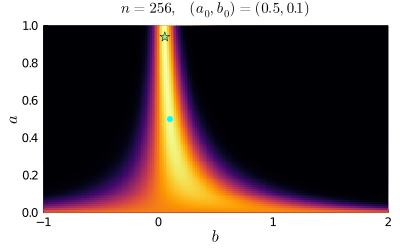

In [11]:
plot_lik(a₀, b₀, 2^8)

#### 尤度関数のプロット: $n=2^{10}$

  0.866460 seconds (2 allocations: 156.328 KiB)


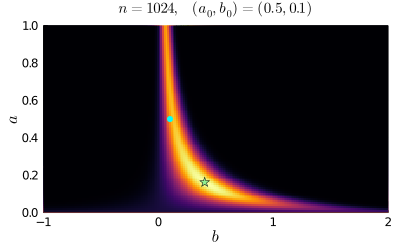

In [12]:
plot_lik(a₀, b₀, 2^10)

#### 尤度関数のプロット: $n=2^{12}$

  3.547601 seconds (2 allocations: 156.328 KiB)


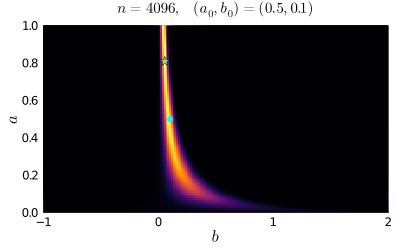

In [13]:
plot_lik(a₀, b₀, 2^12)

#### 尤度関数のプロット: $n=2^{14}$

 15.156593 seconds (2 allocations: 156.328 KiB)


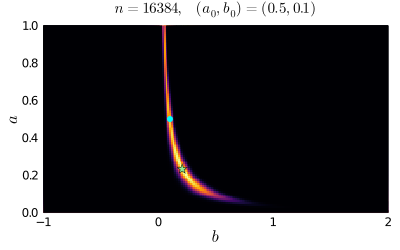

In [14]:
plot_lik(a₀, b₀, 2^14)

### $(a_1, b_1) = (0.5, 0.5)$ regular
- [目次](#目次)

#### まとめ
- $n$が増えるとヒートマップの範囲は細長くなっていく
- （ここで確認した範囲では）ヒートマップの裾野も狭くなる
- 最尤法の位置（星型マーカー）の精度もよい

In [15]:
a₁, b₁ = 0.5, 0.5

(0.5, 0.5)

#### 尤度関数のプロット: $n=2^{4}$

  0.016205 seconds (2 allocations: 156.328 KiB)


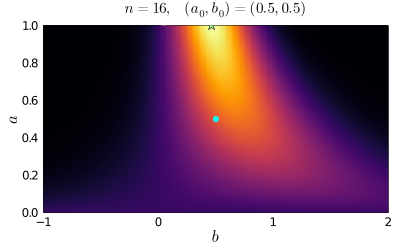

In [16]:
plot_lik(a₁, b₁, 2^4)

#### 尤度関数のプロット: $n=2^{6}$

  0.051732 seconds (2 allocations: 156.328 KiB)


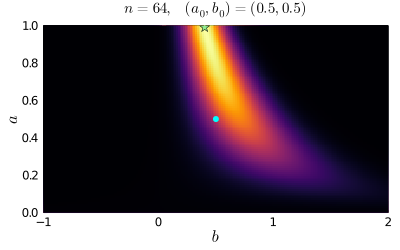

In [17]:
plot_lik(a₁, b₁, 2^6)

#### 尤度関数のプロット: $n=2^{8}$

  0.212294 seconds (2 allocations: 156.328 KiB)


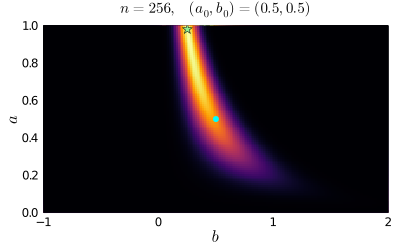

In [18]:
plot_lik(a₁, b₁, 2^8)

#### 尤度関数のプロット: $n=2^{10}$

  0.826504 seconds (2 allocations: 156.328 KiB)


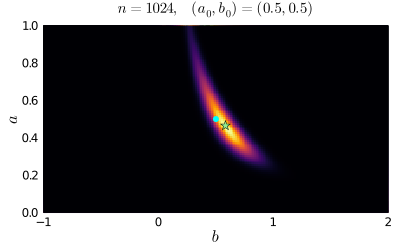

In [19]:
plot_lik(a₁, b₁, 2^10)

#### 尤度関数のプロット: $n=2^{12}$

  3.463599 seconds (2 allocations: 156.328 KiB)


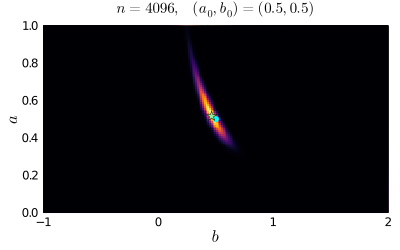

In [20]:
plot_lik(a₁, b₁, 2^12)

#### 尤度関数のプロット: $n=2^{14}$

 14.467399 seconds (2 allocations: 156.328 KiB)


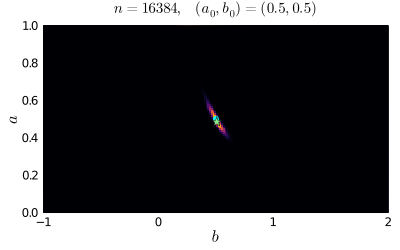

In [21]:
plot_lik(a₁, b₁, 2^14)

### $(a_2, b_2) = (0.5, 0.0)$ singular
- [目次](#目次)

#### まとめ
- $n$が増えるとヒートマップの範囲は細長くなっていく
- （ここで確認した範囲では）ヒートマップの裾野は広い
- 最尤法の位置（星型マーカー）の精度はよくない
- $a=0$で$b$に関する広がりがある

In [22]:
a₂, b₂ = 0.5, 0.0

(0.5, 0.0)

#### 尤度関数のプロット: $n=2^{4}$

  0.012323 seconds (2 allocations: 156.328 KiB)


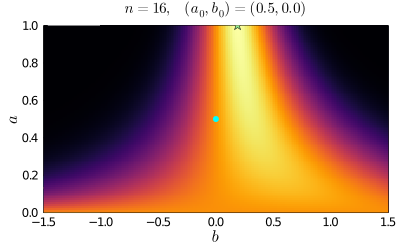

In [23]:
plot_lik(a₂, b₂, 2^4; blim=(-1.5, 1.5))

#### 尤度関数のプロット: $n=2^{6}$

  0.049464 seconds (2 allocations: 156.328 KiB)


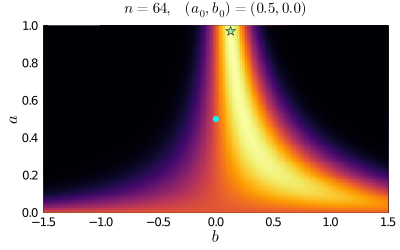

In [24]:
plot_lik(a₂, b₂, 2^6; blim=(-1.5, 1.5))

#### 尤度関数のプロット: $n=2^{8}$

  0.194035 seconds (2 allocations: 156.328 KiB)


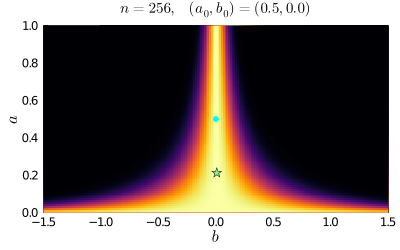

In [25]:
plot_lik(a₂, b₂, 2^8; blim=(-1.5, 1.5))

#### 尤度関数のプロット: $n=2^{10}$

  0.894450 seconds (2 allocations: 156.328 KiB)


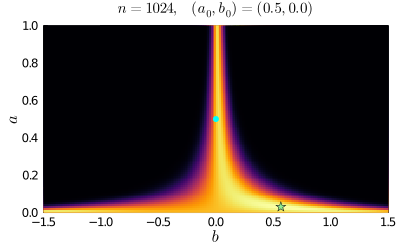

In [26]:
plot_lik(a₂, b₂, 2^10; blim=(-1.5, 1.5))

#### 尤度関数のプロット: $n=2^{12}$

  3.577334 seconds (2 allocations: 156.328 KiB)


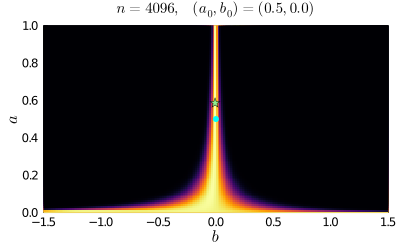

In [27]:
plot_lik(a₂, b₂, 2^12; blim=(-1.5, 1.5))

#### 尤度関数のプロット: $n=2^{14}$

 14.068873 seconds (2 allocations: 156.328 KiB)


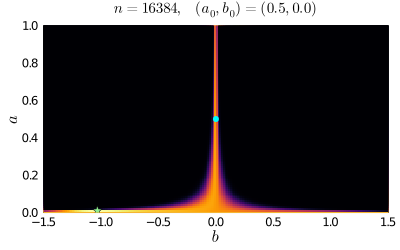

In [28]:
plot_lik(a₂, b₂, 2^14; blim=(-1.5, 1.5))

### $(a_3, b_3) = (0.5, 4.0)$ very regular
- [目次](#目次)

#### まとめ
- $n$が増えるとヒートマップの範囲は同心（楕）円上に小さくなる
- （ここで確認した範囲では）ヒートマップの裾野も狭くなる
- 最尤法の位置（星型マーカー）の精度もよい

In [29]:
a₃, b₃ = 0.5, 4.0

(0.5, 4.0)

#### 尤度関数のプロット: $n=2^{4}$

  0.016058 seconds (2 allocations: 156.328 KiB)


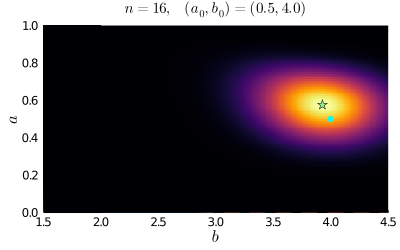

In [30]:
plot_lik(a₃, b₃, 2^4; alim=(0, 1), blim=(1.5, 4.5))

#### 尤度関数のプロット: $n=2^{6}$

  0.057911 seconds (2 allocations: 156.328 KiB)


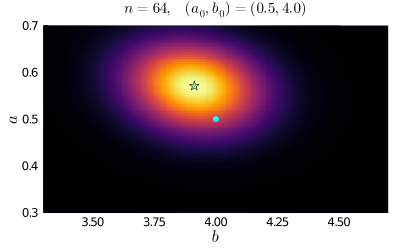

In [31]:
plot_lik(a₃, b₃, 2^6; alim=(0.3, 0.7), blim=(3.3, 4.7))

#### 尤度関数のプロット: $n=2^{8}$

  0.275946 seconds (2 allocations: 156.328 KiB)


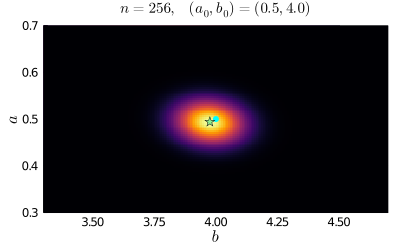

In [32]:
plot_lik(a₃, b₃, 2^8; alim=(0.3, 0.7), blim=(3.3, 4.7))

#### 尤度関数のプロット: $n=2^{10}$

  0.974702 seconds (2 allocations: 156.328 KiB)


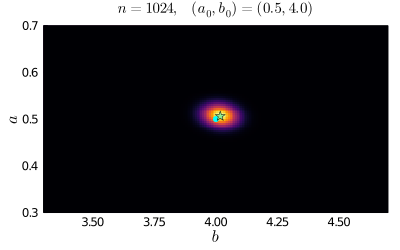

In [33]:
plot_lik(a₃, b₃, 2^10; alim=(0.3, 0.7), blim=(3.3, 4.7))

#### 尤度関数のプロット: $n=2^{12}$

  3.787273 seconds (2 allocations: 156.328 KiB)


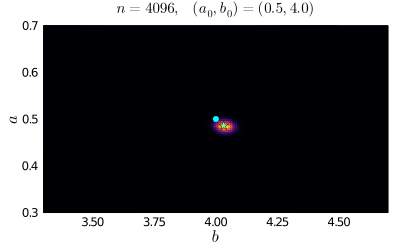

In [34]:
plot_lik(a₃, b₃, 2^12; alim=(0.3, 0.7), blim=(3.3, 4.7))

#### 尤度関数のプロット: $n=2^{14}$

 16.051472 seconds (2 allocations: 156.328 KiB)


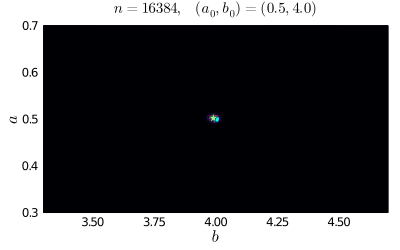

In [35]:
plot_lik(a₃, b₃, 2^14; alim=(0.3, 0.7), blim=(3.3, 4.7))

## n = 256 で固定しつつ、乱数のシードを変えて実験
- [目次](#目次)

### n = 256, $(a_0, b_0) = (0.5, 0.1)$, near singular
- [目次](#目次)

#### まとめ
- $a=0$近くで$b$に関する左右の広がりが大きい

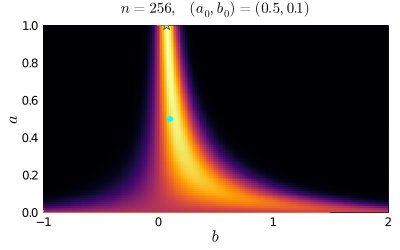

  0.194835 seconds (2 allocations: 156.328 KiB)

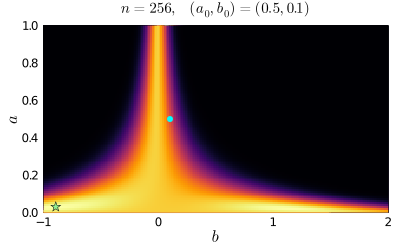


  0.196103 seconds (2 allocations: 156.328 KiB)

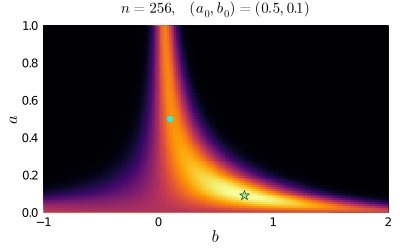


  0.194964 seconds (2 allocations: 156.328 KiB)


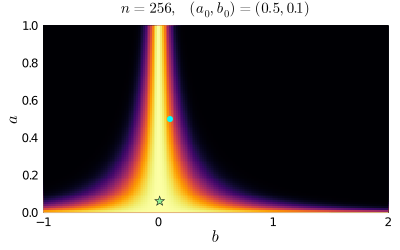

  0.194931 seconds (2 allocations: 156.328 KiB)


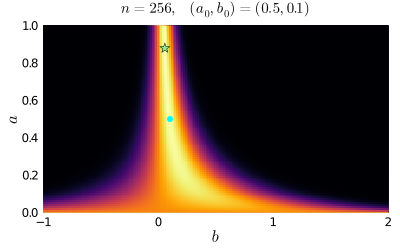

  0.195621 seconds (2 allocations: 156.328 KiB)

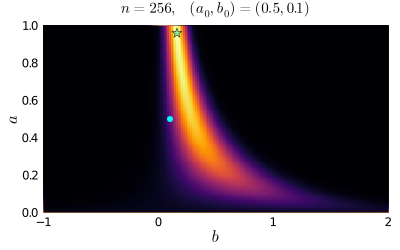


  0.200231 seconds (2 allocations: 156.328 KiB)


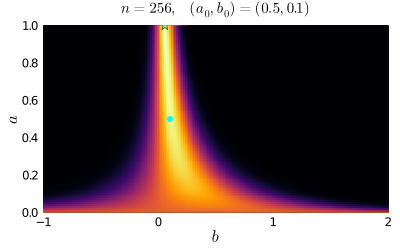

  0.229683 seconds (2 allocations: 156.328 KiB)


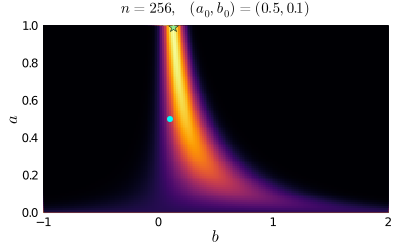

  0.196436 seconds (2 allocations: 156.328 KiB)

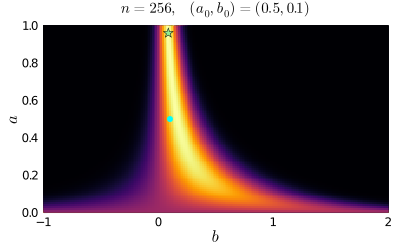


  0.201515 seconds (2 allocations: 156.328 KiB)


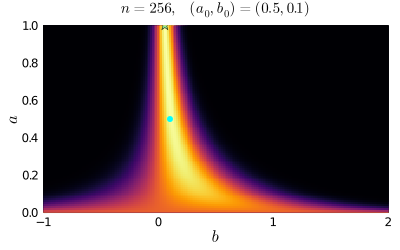

  0.204171 seconds (2 allocations: 156.328 KiB)


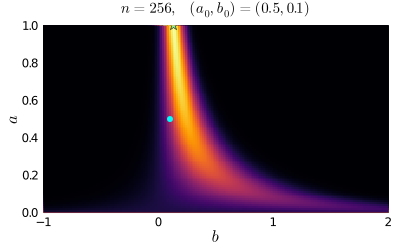

  0.249203 seconds (2 allocations: 156.328 KiB)


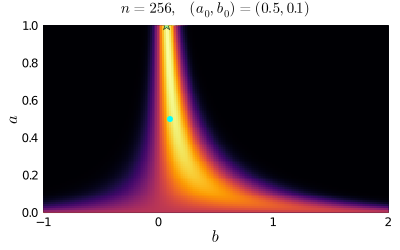

  0.215640 seconds (2 allocations: 156.328 KiB)


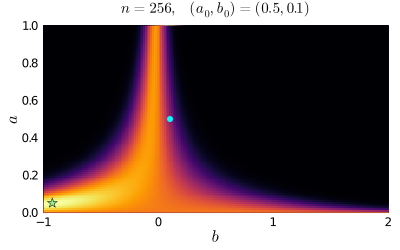

  0.194103 seconds (2 allocations: 156.328 KiB)


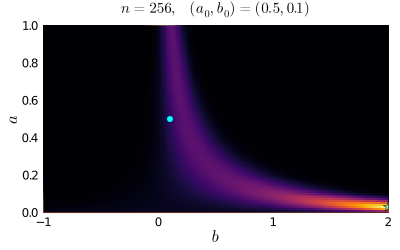

  0.195474 seconds (2 allocations: 156.328 KiB)


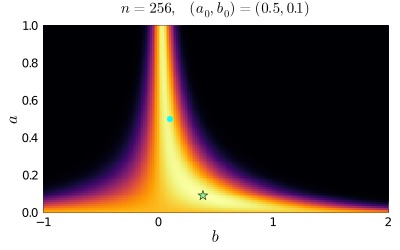

  0.195167 seconds (2 allocations: 156.328 KiB)


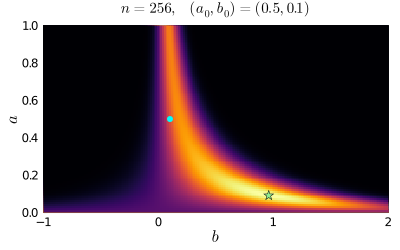

  0.219602 seconds (2 allocations: 156.328 KiB)


In [36]:
for i in 1:loopnum
    plot_lik(a₀, b₀, 2^8; seed=rands[i]) |> display
end

### n = 256, $(a_1, b_1) = (0.5, 0.5)$, regular
- [目次](#目次)

#### まとめ
- 三日月型で$b$が小さい方には振れない

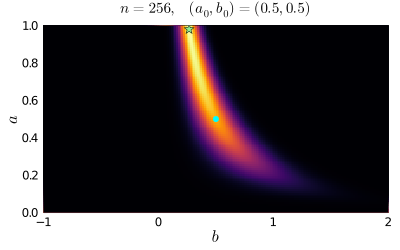

  0.205081 seconds (2 allocations: 156.328 KiB)


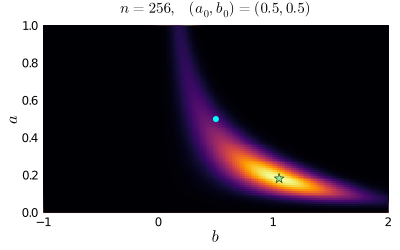

  0.198506 seconds (2 allocations: 156.328 KiB)

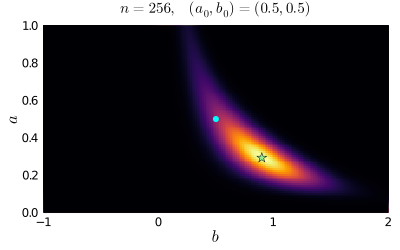


  0.206731 seconds (2 allocations: 156.328 KiB)


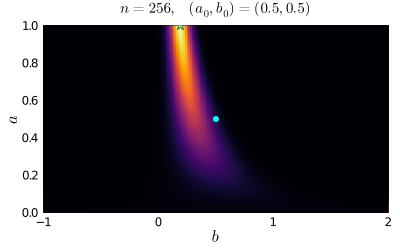

  0.207015 seconds (2 allocations: 156.328 KiB)


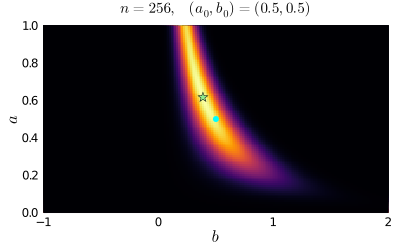

  0.215802 seconds (2 allocations: 156.328 KiB)

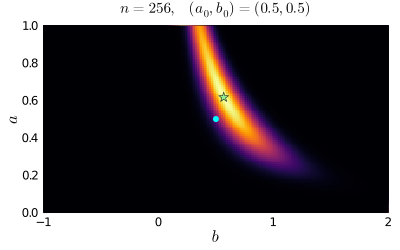


  0.209595 seconds (2 allocations: 156.328 KiB)

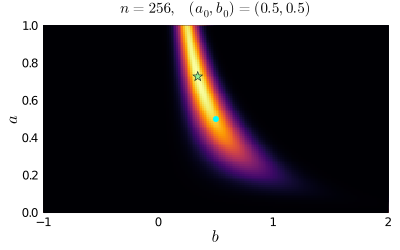


  0.240659 seconds (2 allocations: 156.328 KiB)

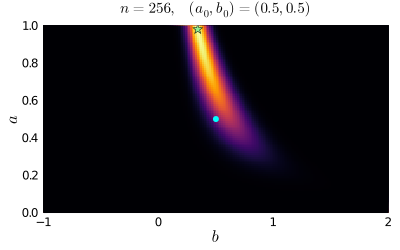


  0.191976 seconds (2 allocations: 156.328 KiB)


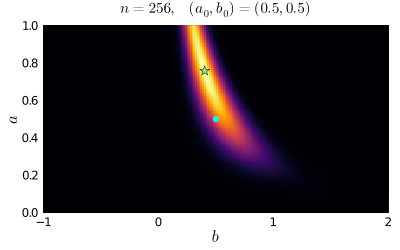

  0.206976 seconds (2 allocations: 156.328 KiB)


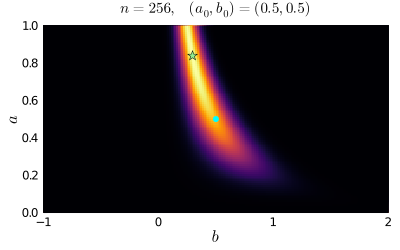

  0.203254 seconds (2 allocations: 156.328 KiB)


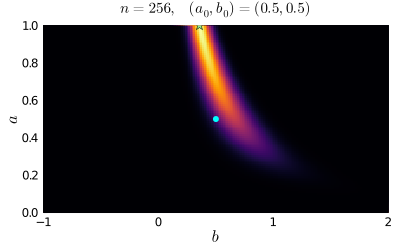

  0.203807 seconds (2 allocations: 156.328 KiB)

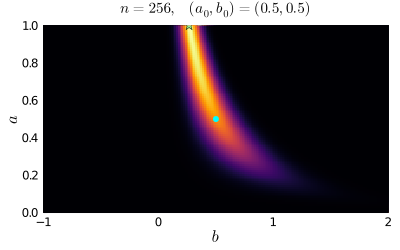


  0.191533 seconds (2 allocations: 156.328 KiB)

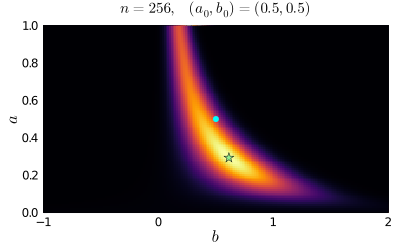


  0.196072 seconds (2 allocations: 156.328 KiB)

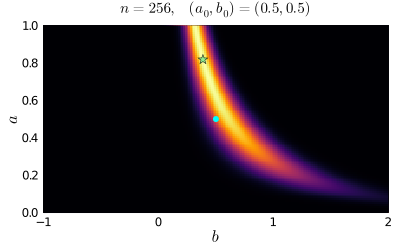


  0.193212 seconds (2 allocations: 156.328 KiB)


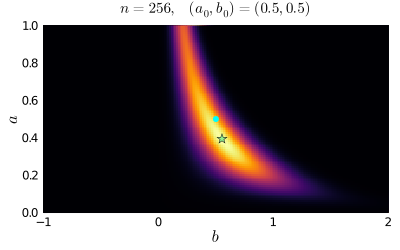

  0.201809 seconds (2 allocations: 156.328 KiB)

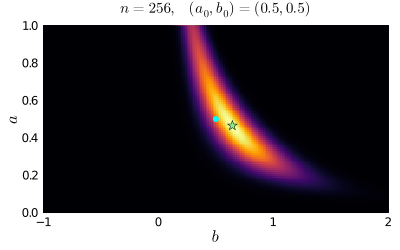


  0.227993 seconds (2 allocations: 156.328 KiB)


In [37]:
for i in 1:16
    plot_lik(a₁, b₁, 2^8; seed=rands[i]) |> display
end

### n = 256, $(a_2, b_2) = (0.5, 0.0)$, singular
- [目次](#目次)

#### まとめ
- $a=0$ の近くでの$b$方向の広がりが大きい
- 最尤法の精度はひどい

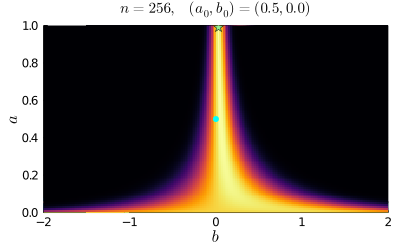

  0.216203 seconds (2 allocations: 156.328 KiB)

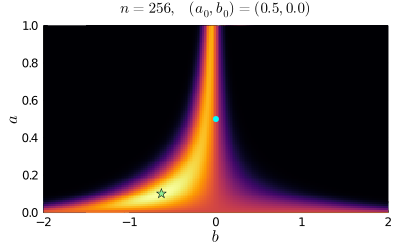


  0.223301 seconds (2 allocations: 156.328 KiB)

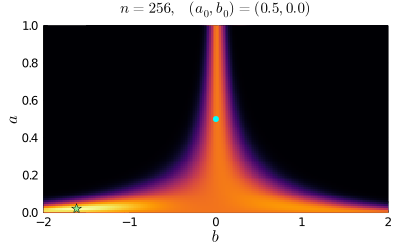


  0.209527 seconds (2 allocations: 156.328 KiB)

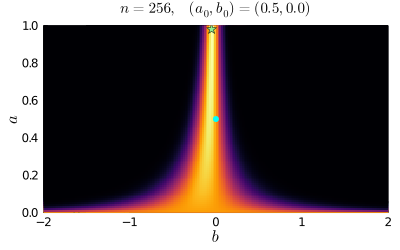


  0.207481 seconds (2 allocations: 156.328 KiB)

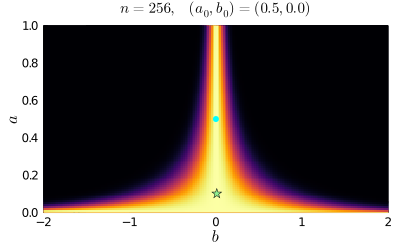


  0.197960 seconds (2 allocations: 156.328 KiB)


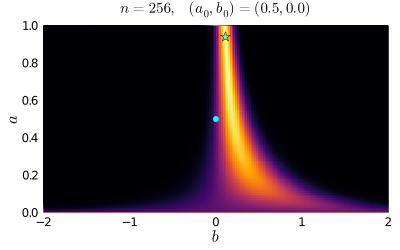

  0.206841 seconds (2 allocations: 156.328 KiB)


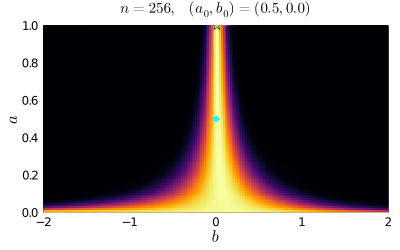

  0.198022 seconds (2 allocations: 156.328 KiB)

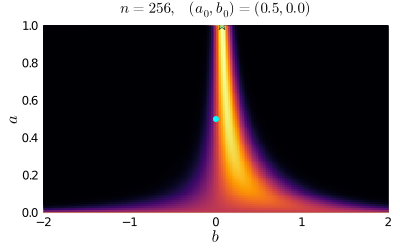


  0.199898 seconds (2 allocations: 156.328 KiB)

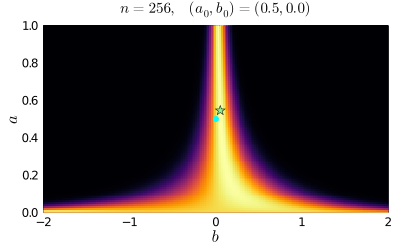


  0.200614 seconds (2 allocations: 156.328 KiB)


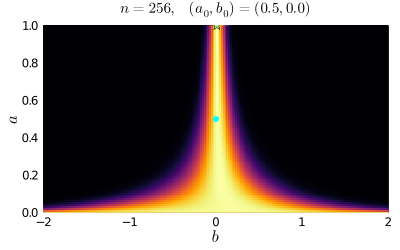

  0.200782 seconds (2 allocations: 156.328 KiB)

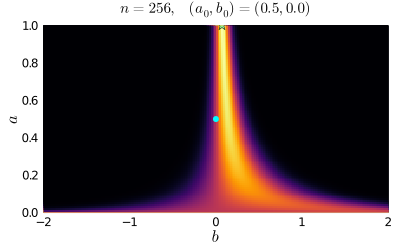


  0.198917 seconds (2 allocations: 156.328 KiB)

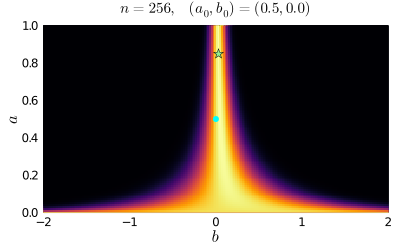


  0.213872 seconds (2 allocations: 156.328 KiB)


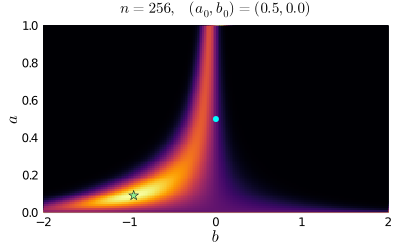

  0.214565 seconds (2 allocations: 156.328 KiB)


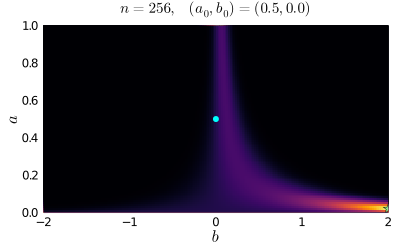

  0.209804 seconds (2 allocations: 156.328 KiB)

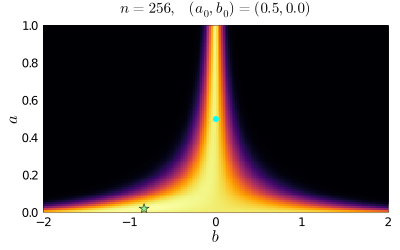


  0.236491 seconds (2 allocations: 156.328 KiB)


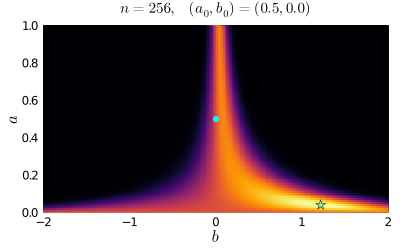

  0.205849 seconds (2 allocations: 156.328 KiB)


In [38]:
for i in 1:loopnum
    plot_lik(a₂, b₂, 2^8; blim=(-2, 2), seed=rands[i]) |> display
end

### n = 256, $(a_3, b_3) = (0.5, 4.0)$, very regular
- [目次](#目次)

#### まとめ
- ヒートマップの広がり自体は同心円状
- 最尤法の値（円の中心）自体は真の値に近いことがある（多少ずれていることもある）
    - ほかのグラフと比較するときは軸の範囲にも注意すること！

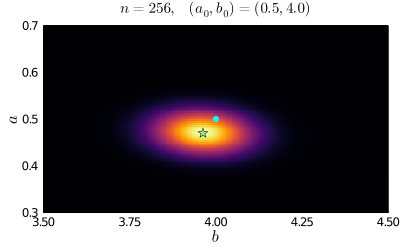

  0.250845 seconds (2 allocations: 156.328 KiB)

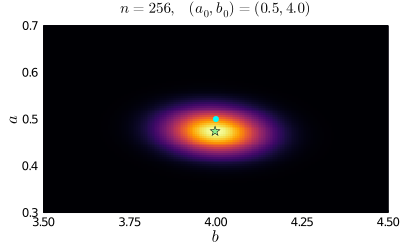


  0.232996 seconds (2 allocations: 156.328 KiB)


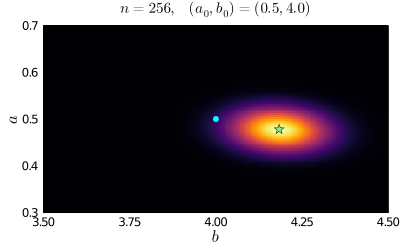

  0.241303 seconds (2 allocations: 156.328 KiB)


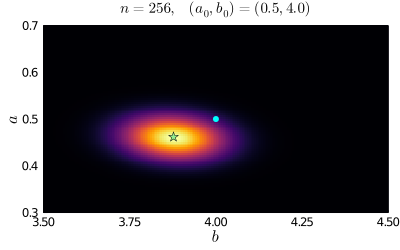

  0.258963 seconds (2 allocations: 156.328 KiB)


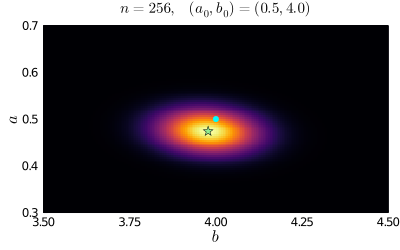

  0.248003 seconds (2 allocations: 156.328 KiB)


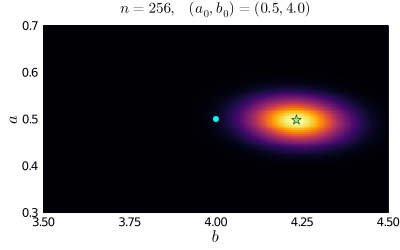

  0.237971 seconds (2 allocations: 156.328 KiB)

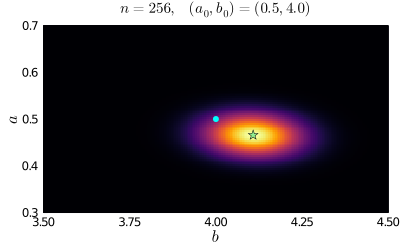


  0.244892 seconds (2 allocations: 156.328 KiB)

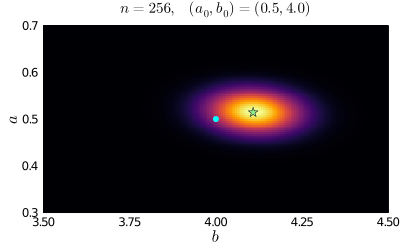


  0.249263 seconds (2 allocations: 156.328 KiB)

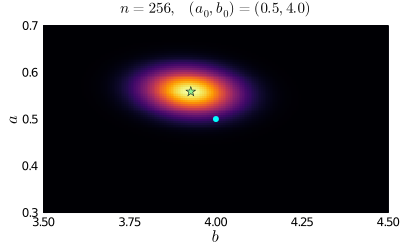


  0.246787 seconds (2 allocations: 156.328 KiB)


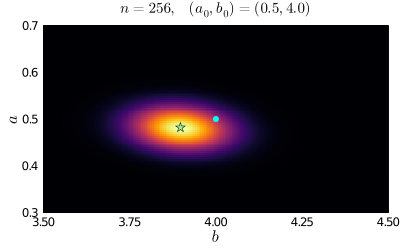

  0.311288 seconds (2 allocations: 156.328 KiB)


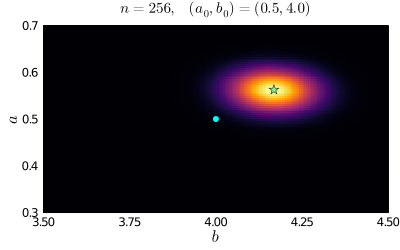

  0.257164 seconds (2 allocations: 156.328 KiB)

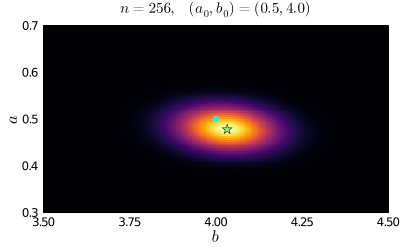


  0.238119 seconds (2 allocations: 156.328 KiB)

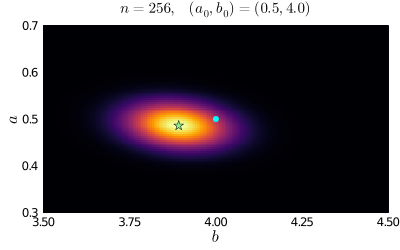


  0.277796 seconds (2 allocations: 156.328 KiB)


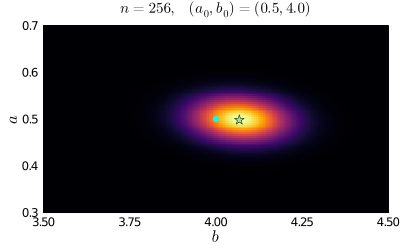

  0.237881 seconds (2 allocations: 156.328 KiB)


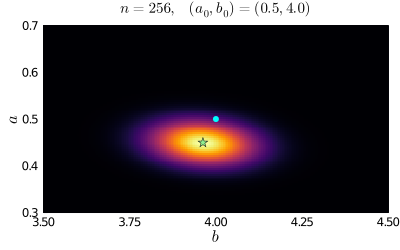

  0.271019 seconds (2 allocations: 156.328 KiB)

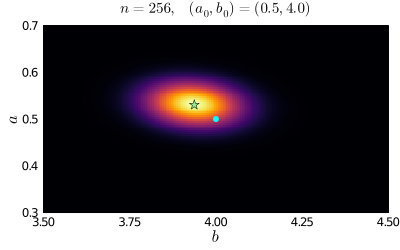


  0.248705 seconds (2 allocations: 156.328 KiB)


In [39]:
for i in 1:loopnum
    plot_lik(a₃, b₃, 2^8; alim=(0.3, 0.7), blim=(3.5, 4.5), seed=rands[i]) |> display
end